In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from skimage import color
from scipy import misc
import cv2
import matplotlib.ticker as ticker
from math import ceil
from os import listdir
from os import path
from collections import Counter
import timeit

# Служебные функции для характеризации работы моделей

In [2]:
def tile(img_path, w, h, step_w, step_h):
    """Нарезает исходное изображение, считываемое из файла по адресу img_path
    на тайлы размером w x h с шагом step_w и step_h по осям x и y соответственно.
    Если на изображении не помещается целое количество тайлов, справа и снизу к
    изображению добавляются белые поля.
    Возвращает numpy-массив с тайлами."""
    img = cv2.imread(img_path)
    height, width, _ = img.shape
    total_cols = ceil(width / step_w)
    total_rows = ceil(height / step_h)
    tiles_cnt =  total_cols * total_rows
    tiles = np.ones((tiles_cnt, h, w, 3), np.uint8) * 255
    n = 0
    for i in range(0, total_cols * step_w, step_w):
        for j in range(0, total_rows * step_h, step_h):
            j1 = min(j + step_h, img.shape[0])
            i1 = min(i + step_w, img.shape[1])
            tiles[n][0:j1-j, 0:i1-i, :] = img[j:j1, i:i1, :]
            n += 1
    return tiles

In [3]:
def predict_on_file(filename, k):
    """Осуществляет предсказание класса для изображения, находящегося по адресу filename"""
    tiles = tile(filename, *input_shape[:2], step_w, step_h)
    predict = model.predict(tiles, batch_size=32, verbose=0)
    mean_predict = np.mean(predict, axis=0)
    if mean_predict[0] > k * mean_predict[1]:
        return 'good'
    else:
        return 'bad'

In [4]:
def samples_from_dir(folder):
    """Возвращает список файлов в каталоге folder, исключая файлы разметки"""
    files = []
    for file in listdir(folder):
        if file.endswith('.png') and not file.endswith('_bg.png') and not file.endswith('_mask.png'):
            files.append(path.join(folder, file))
    return files

In [5]:
def classify_predict(predict, gt):
    """По значению predict (предсказание классификатора) и gt (правильный ответ)
    определяет, правильно или нет выполнено предсказание"""
    if predict == 'bad' and gt == 'bad':
        return 'true_positive'
    elif predict == 'good' and gt == 'good':
        return 'true_negative'
    elif predict == 'good' and gt == 'bad':
        return 'false_negative'
    elif predict == 'bad' and gt == 'good':
        return 'false_positive'

# Загрузка валидационных данных

In [6]:
good_files = samples_from_dir('../data/test_good/')
bad_files = samples_from_dir('../data/test_bad/')
print('Good samples:', len(good_files))
print('Bad samples:', len(bad_files))
test_files = dict([[x, 'good'] for x in good_files] + [[x, 'bad'] for x in bad_files])

Good samples: 11
Bad samples: 40


# Валидация классического алгоритма компьютерного зрения

In [7]:
import fat_detector_cv
result = {}
start_time = timeit.default_timer()
for img, gt in test_files.items():
    predict = fat_detector_cv.predict(img)[0]
    result[img] = classify_predict(predict, gt)
    
elapsed = timeit.default_timer() - start_time

stat = {'true_positive': 0,
        'true_negative': 0,
        'false_negative': 0,
        'false_positive': 0}
stat.update(Counter(result.values()))

print('Statistics:', stat)
print('Accuracy:', (stat['true_positive'] + stat['true_negative']) / sum(stat.values()))
print('Performance: {:.2f} images/s'.format(len(test_files) / elapsed))

Statistics: {'true_positive': 40, 'true_negative': 11, 'false_negative': 0, 'false_positive': 0}
Accuracy: 1.0
Performance: 3.48 images/s


../data/test_good/download (18).png 
 Class:  good 
 Fat percent:  2.5064389243206424


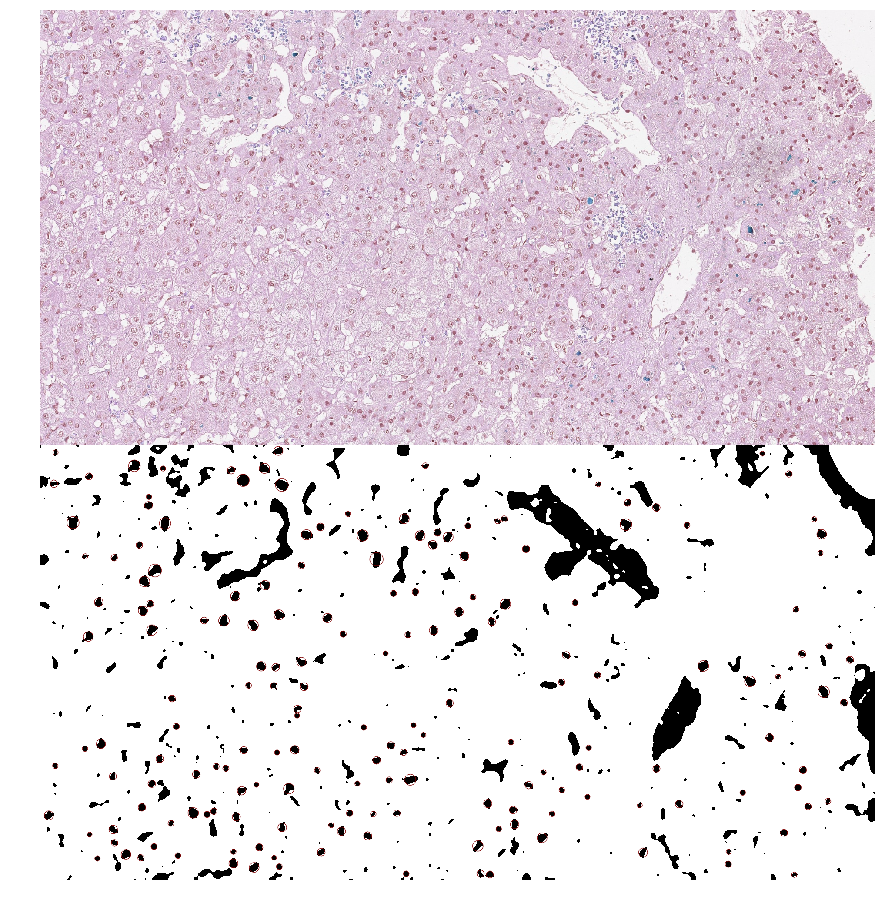

In [8]:
import random
random_image = random.choice(list(test_files))
prediction = fat_detector_cv.predict_and_visualize(random_image)
source = cv2.imread(random_image)
result = np.vstack((source, prediction))
_, ax = plt.subplots(figsize=(16, 16))
ax.imshow(result)
ax.set_axis_off()
plt.show()

# Валидация нейросетевого алгоритма

In [9]:
from model import create_model # импорт функции создания модели

# Задание параметров работы
input_shape = (512, 512, 3) # Размер окна
step_w, step_h = 512, 512 # Шаг, с которым окно проходит изображению по осям x и y соответственно
n_classes = 3 # Модель классифицирует тайлы по трем классам: good, bad, bckground
weights = 'weights.hdf5' # путь к файлу весов
model = create_model(input_shape, n_classes, weights, False) # создаем модель

/home/neuro/anaconda3/envs/neuro/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [10]:
result = {}
start_time = timeit.default_timer()
for img, gt in test_files.items():
    predict = predict_on_file(img, 1)
    result[img] = classify_predict(predict, gt)
elapsed = timeit.default_timer() - start_time

stat = {'true_positive': 0,
        'true_negative': 0,
        'false_negative': 0,
        'false_positive': 0}
stat.update(Counter(result.values()))

print('Statistics:', stat)
print('Accuracy:', (stat['true_positive'] + stat['true_negative']) / sum(stat.values()))
print('Performance: {:.2f} images/s'.format(len(test_files) / elapsed))

Statistics: {'true_positive': 40, 'true_negative': 11, 'false_negative': 0, 'false_positive': 0}
Accuracy: 1.0
Performance: 4.82 images/s
